In [5]:
import re
from os.path import join

import numpy as np
import pandas as pd
import spacy
from spacy.tokens import Doc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter

In [6]:
def custom_tokenizer(text):
    tokens = text.split(" ")
    return Doc(nlp.vocab, tokens)

In [7]:
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'textcat'])

In [8]:
nlp.tokenizer = custom_tokenizer

In [9]:
subset = 'train'
path = f"../../data/QA/ConvQuestions/{subset}_set/"
df = pd.read_csv(join(path, f'cq_{subset}_all.csv'))
df.head()

,Question,Answer,Wikipedia_ID
0,When did The Carpenters sign with A&M Records?,1969,https://en.wikipedia.org/wiki/The_Carpenters
1,Does Bradley Cooper star in American Hustle?,Yes,https://en.wikipedia.org/wiki/American_Hustle
2,What year did the Carpenters sign with A&M Rec...,1969,https://en.wikipedia.org/wiki/The_Carpenters
3,Which author wrote the novel 1Q84?,Haruki Murakami,https://en.wikipedia.org/wiki/1Q84
4,Which famous author wrote the fantasy book ser...,J. K. Rowling,https://en.wikipedia.org/wiki/Harry_Potter


In [10]:
len(df)

414

In [11]:
def question_type(question):
    categories = {
        'who', 'what', 'which',
        'why', 'where', 'when', 'how'
    }
    doc = nlp(" ".join([word for word in question.split(" ")if word]))
    # get w-question
    marker = [token.text for token in doc if token.head.pos_ in {'AUX', 'VERB'} and token.text in categories]
    if not marker:
        # get w-question elsehwere in the text
        marker = [token.text for token in doc if token.text in categories]
        if not marker:
            # get auxiliary verb
            marker = [token.text for token in doc if token.pos_=='AUX' or token.dep_=='aux']
            if not marker:
                # get verb
                marker = [token.text for token in doc if token.pos_=='VERB']
                if not marker:
                    # get root
                    marker = [token.text for token in doc if token.head==token]
    return marker[0]

In [12]:
tqdm.pandas()

/proj/mahoni/anaconda3/envs/py37/lib/python3.7/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [13]:
question_analysis = df['Question'].str.lower().replace(r'([^\w\d\s.!?\\-])', '', regex=True).progress_apply(question_type)

In [14]:
q_counter = Counter(question_analysis)

In [15]:
q_counter.most_common(10)

[('what', 150),
 ('who', 104),
 ('which', 52),
 ('when', 16),
 ('how', 15),
 ('where', 13),
 ('did', 12),
 ('whats', 10),
 ('the', 6),
 ('name', 5)]

In [16]:
total = sum(q_counter.values())
categories = {
        'who', 'what', 'which',
        'why', 'where', 'when', 'how'
    }
percentage_q_words = round(sum(q_counter[category] for category in categories)/total, 2)
percentage_q_words

0.85

In [17]:
category_count = {category: q_counter[category] for category in categories if q_counter[category] > 0}
category_count

{'how': 15, 'who': 104, 'where': 13, 'what': 150, 'when': 16, 'which': 52}

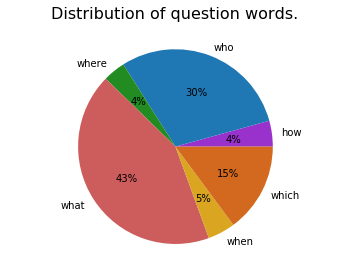

In [18]:
# Ploat a pie chart using percentages
fig, ax = plt.subplots()
labels, shares = zip(*category_count.items())
#add colors
colors = ['darkorchid', 'tab:blue', 'forestgreen', 'indianred', 'goldenrod', 'chocolate', ]

ax.pie(shares, labels=labels, colors=colors, autopct="%1.0f%%", shadow=False)
ax.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

ax.set_title("Distribution of question words.", fontsize=16, pad=20)

plt.show()

In [19]:
df_entity = pd.DataFrame(columns=nlp.entity.labels)
for answer in tqdm(df['Answer']):
    entity_counter = Counter([entity.label_ for entity in nlp(answer).ents])
    df_entity = df_entity.append([{entity: entity_counter[entity] for entity in nlp.entity.labels}])
df_entity = df_entity.reset_index(drop=True)

how


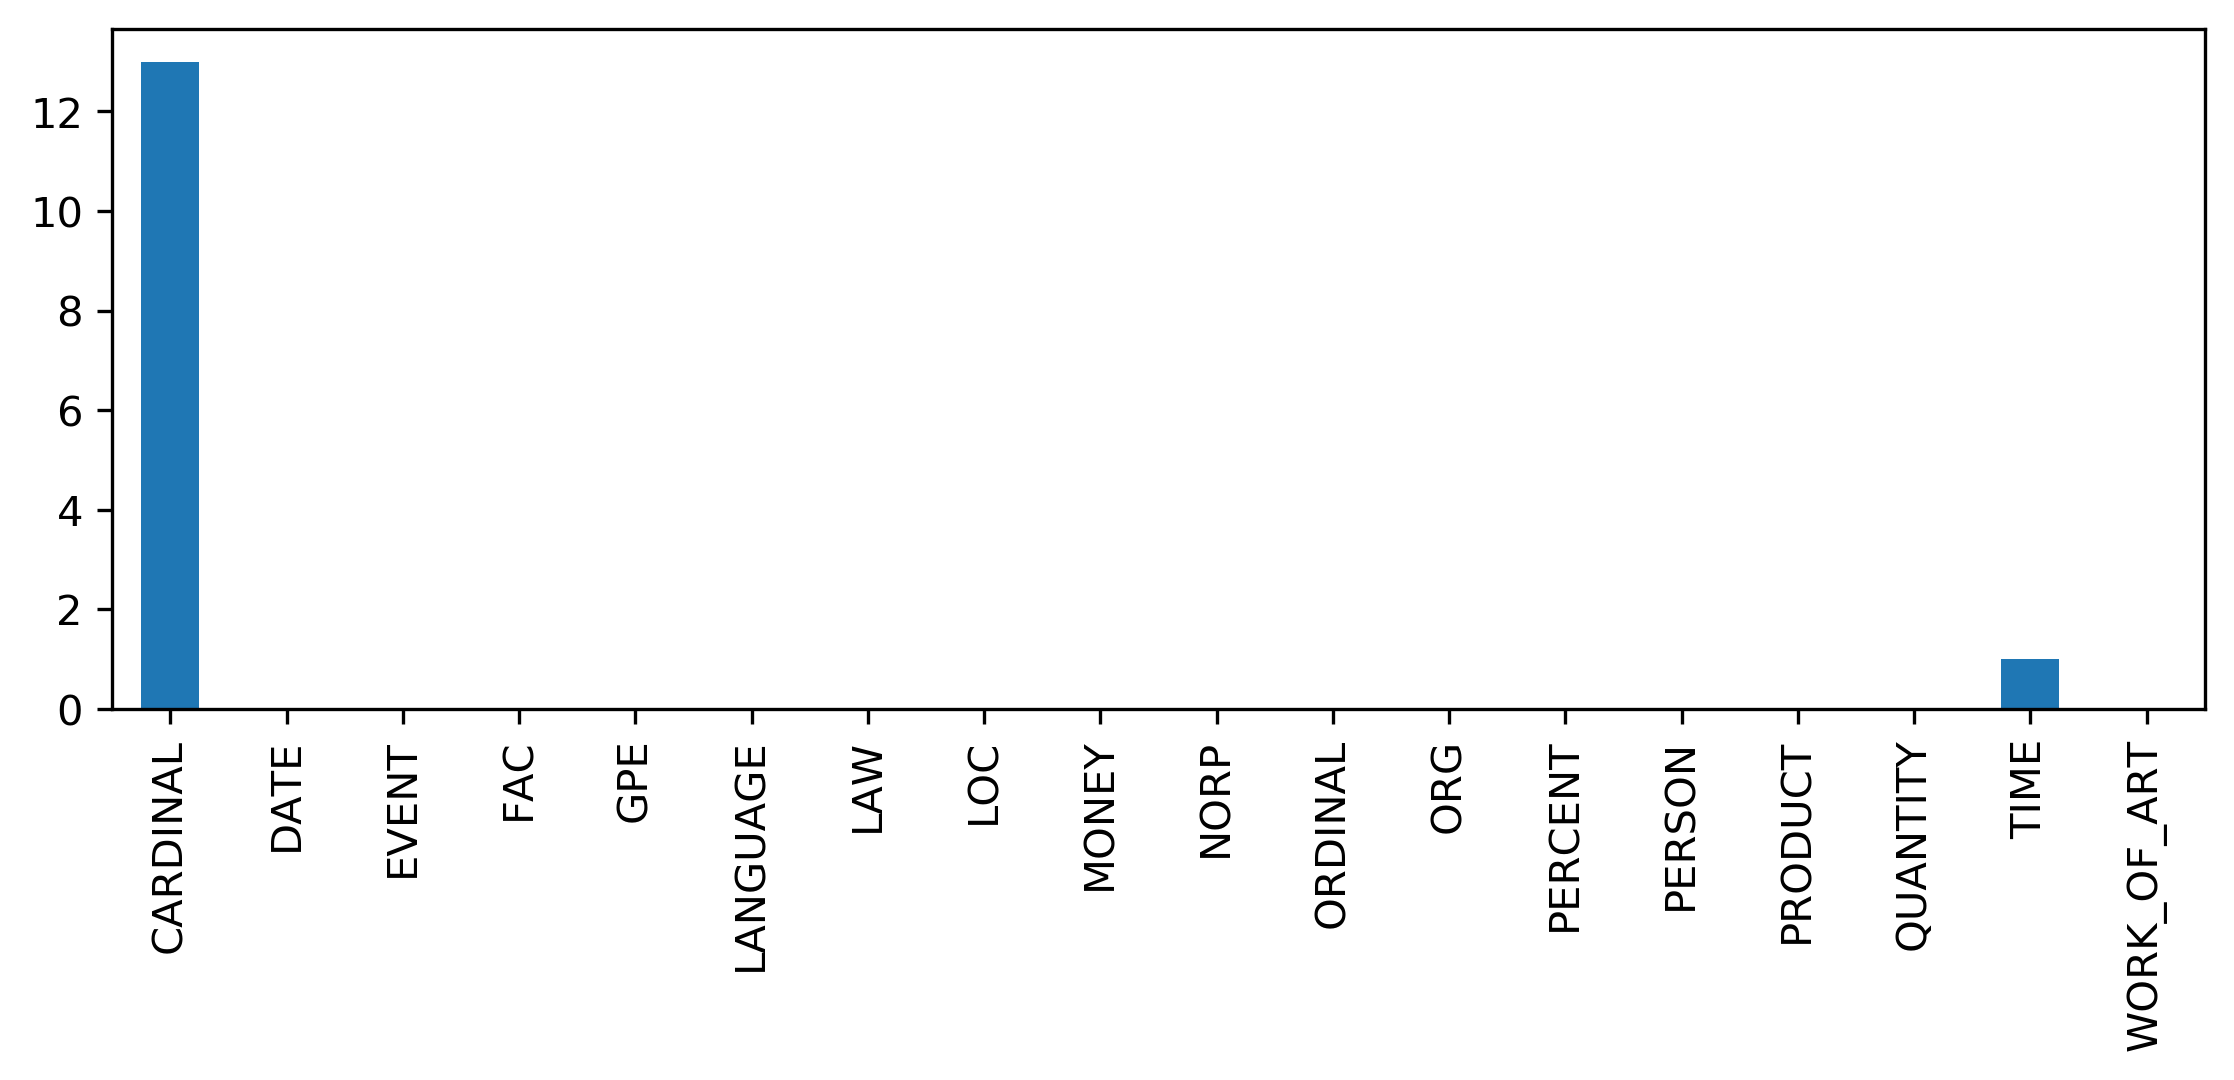

who


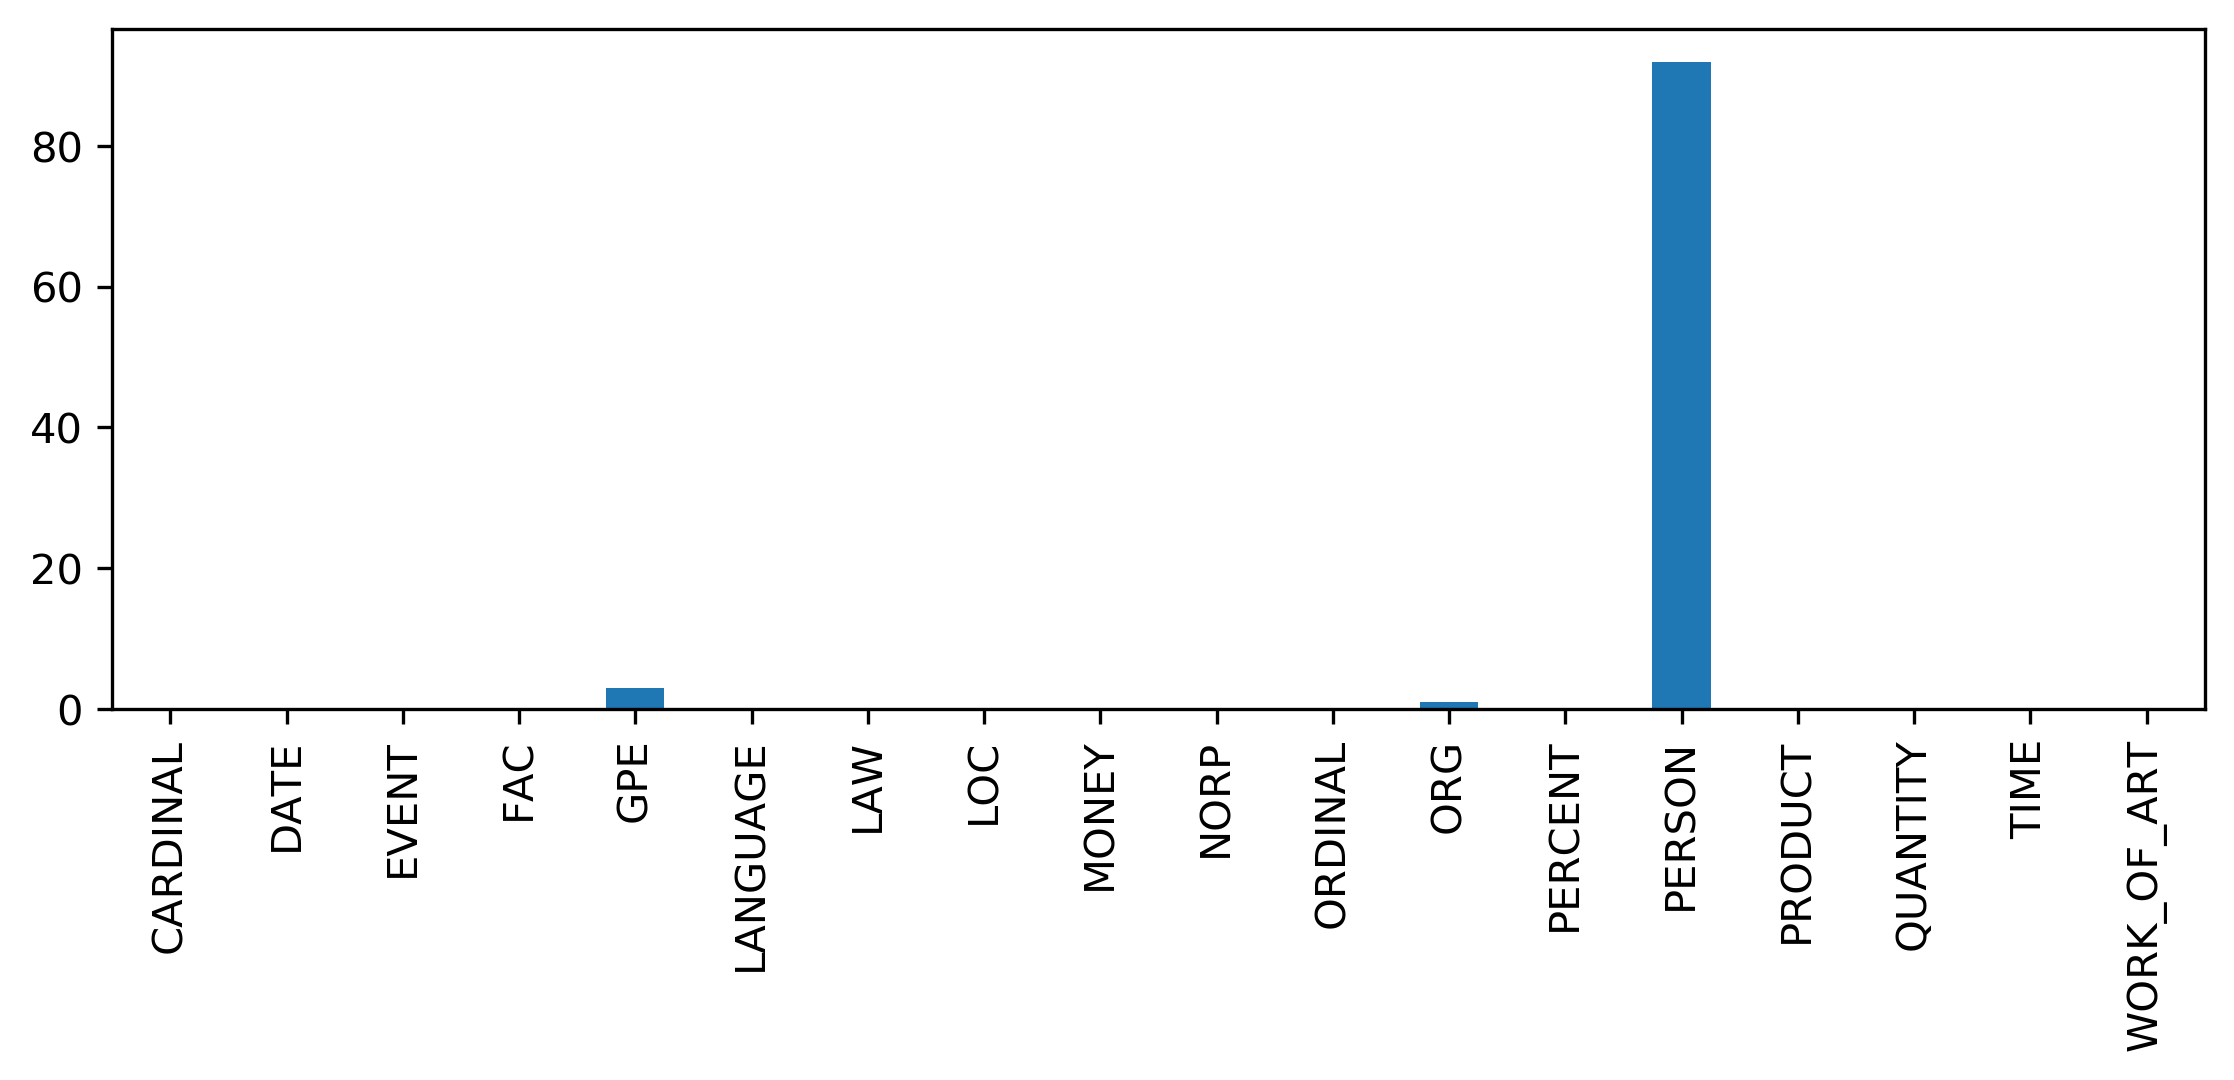

where


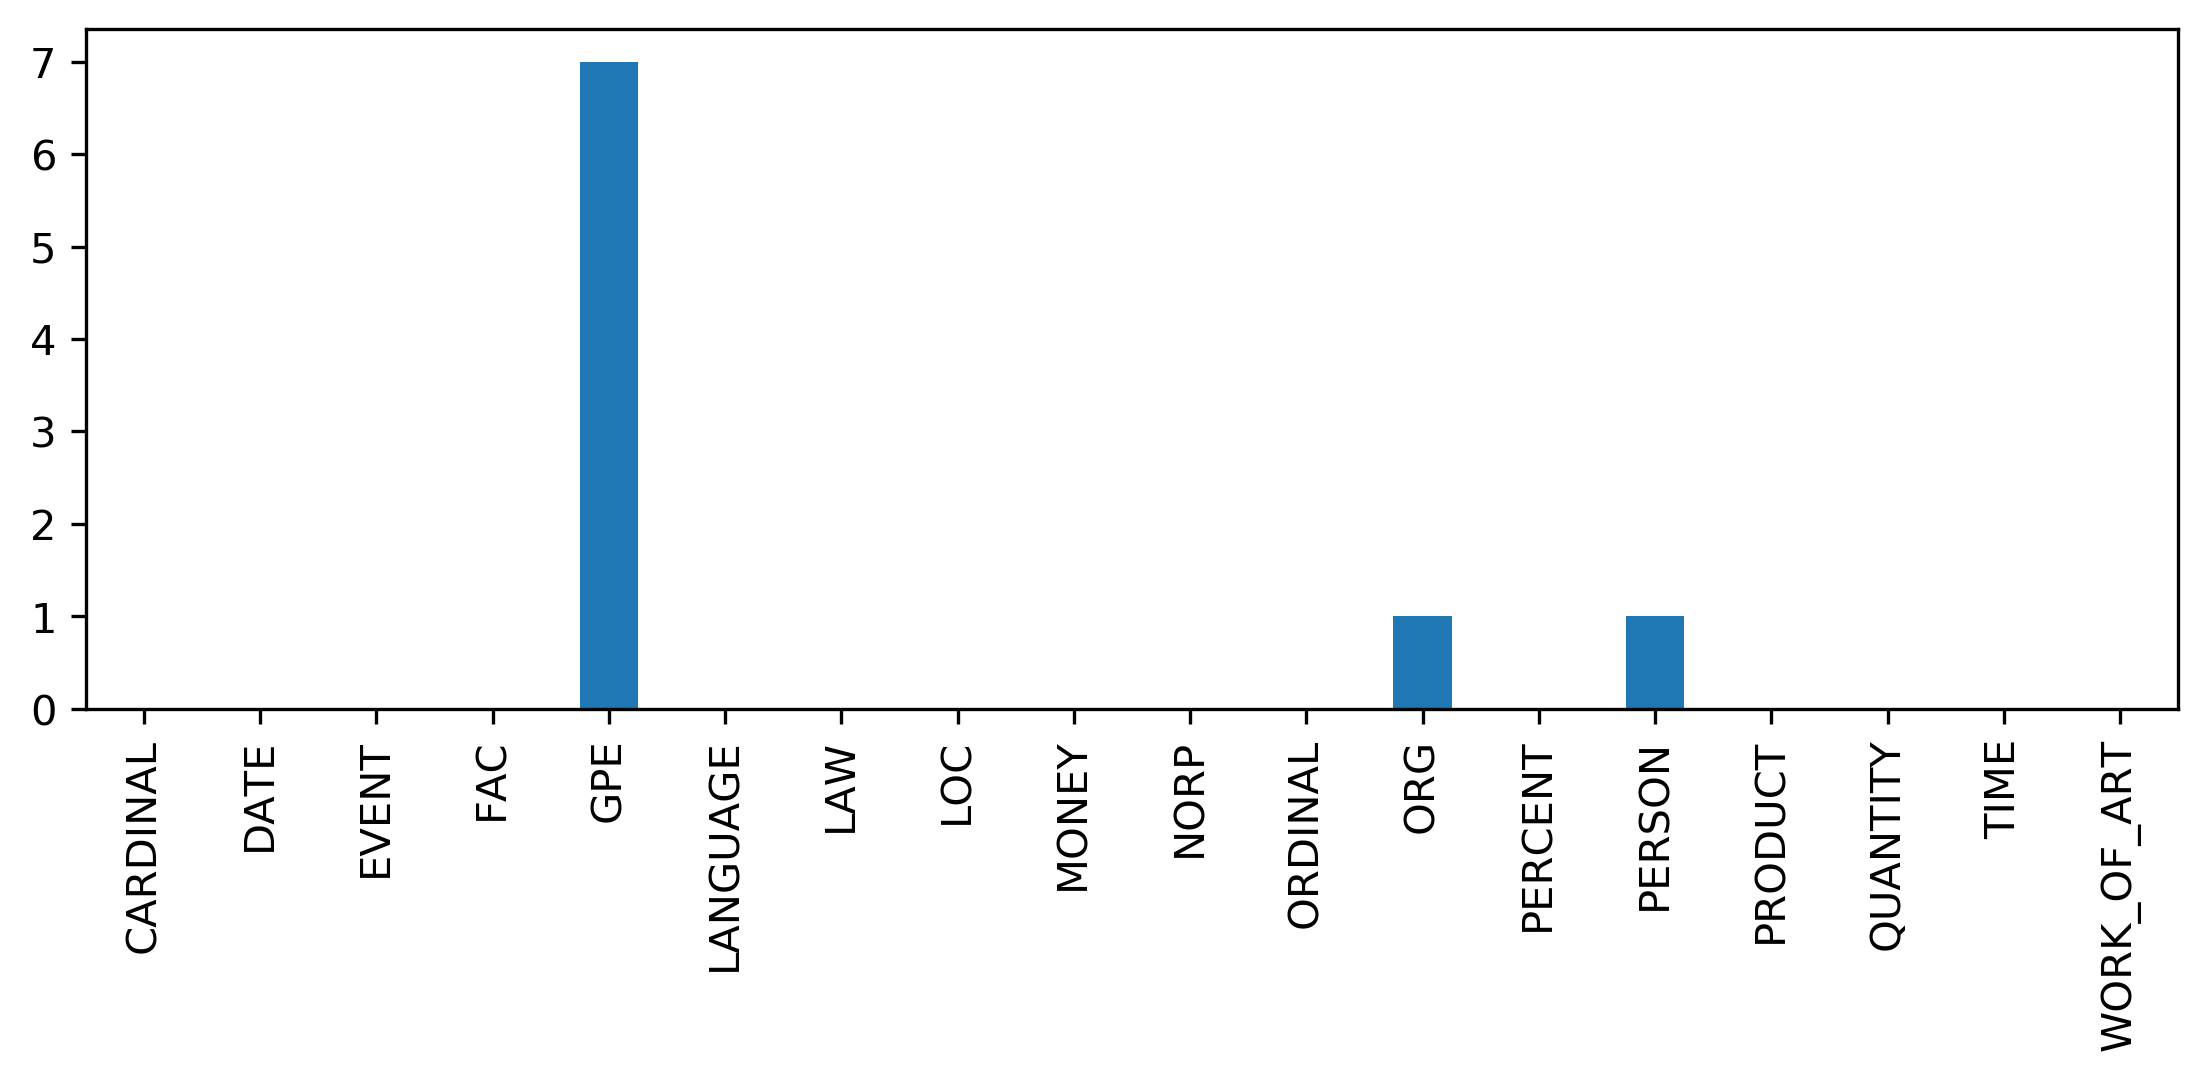

what


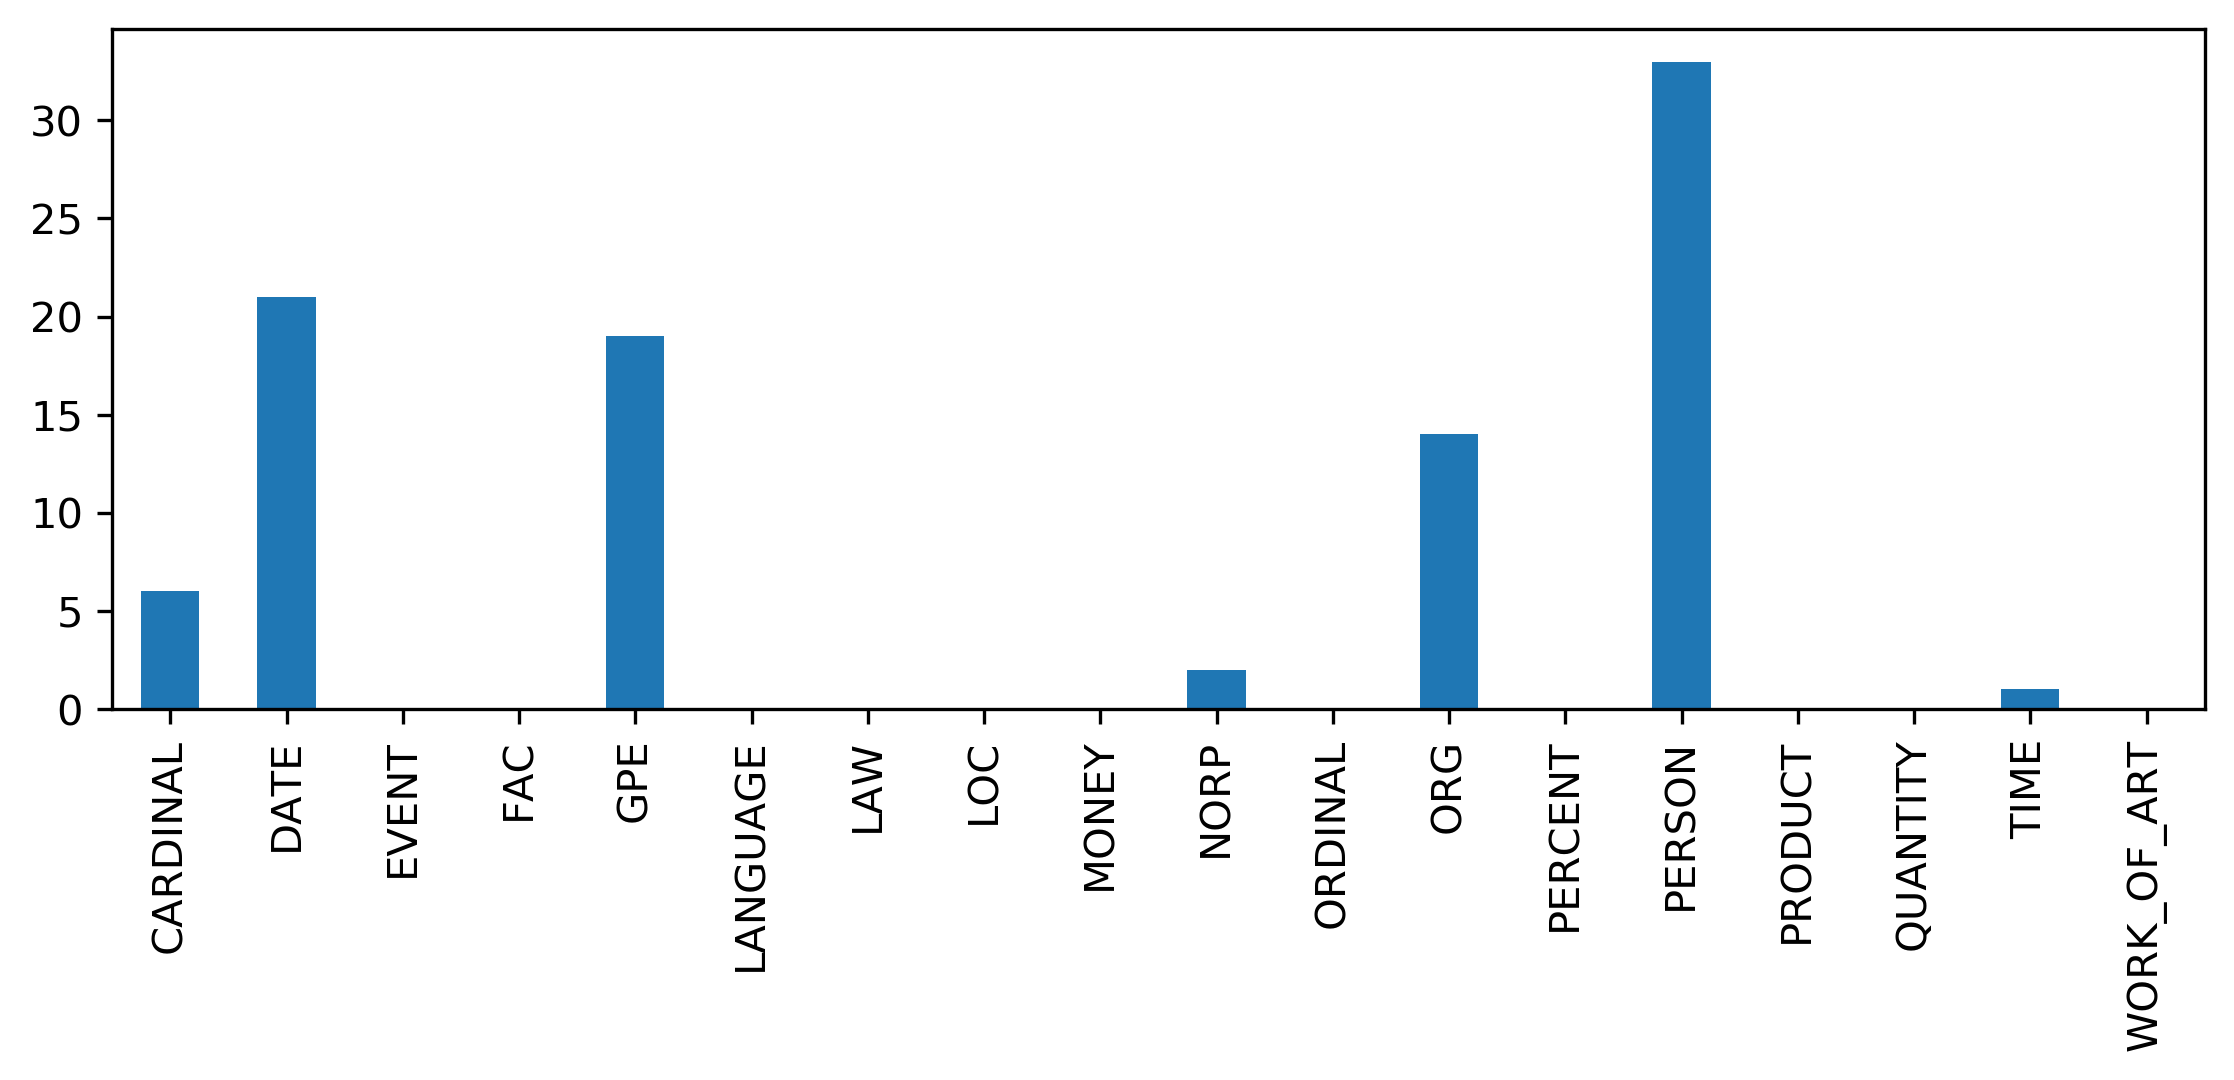

when


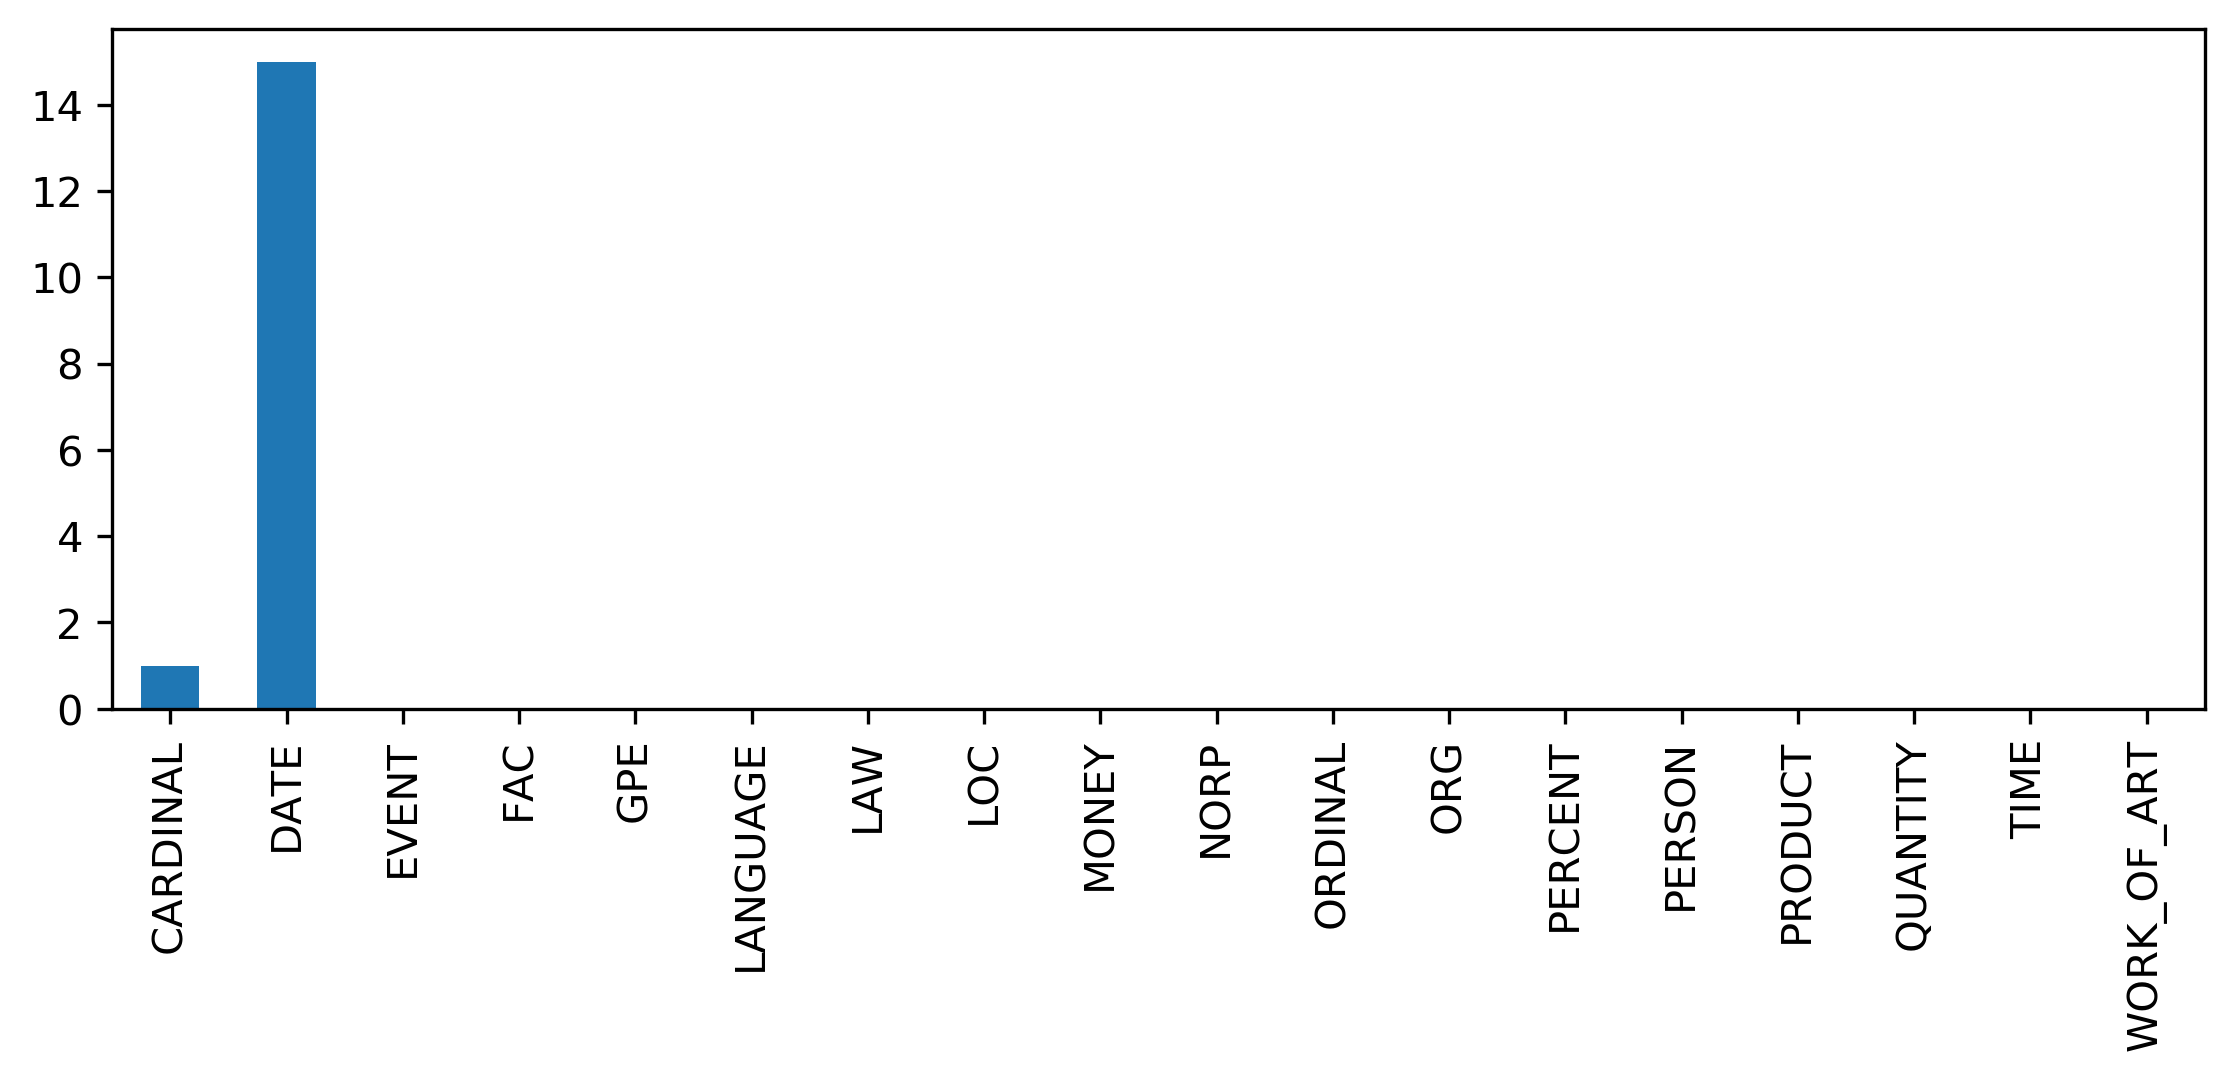

which


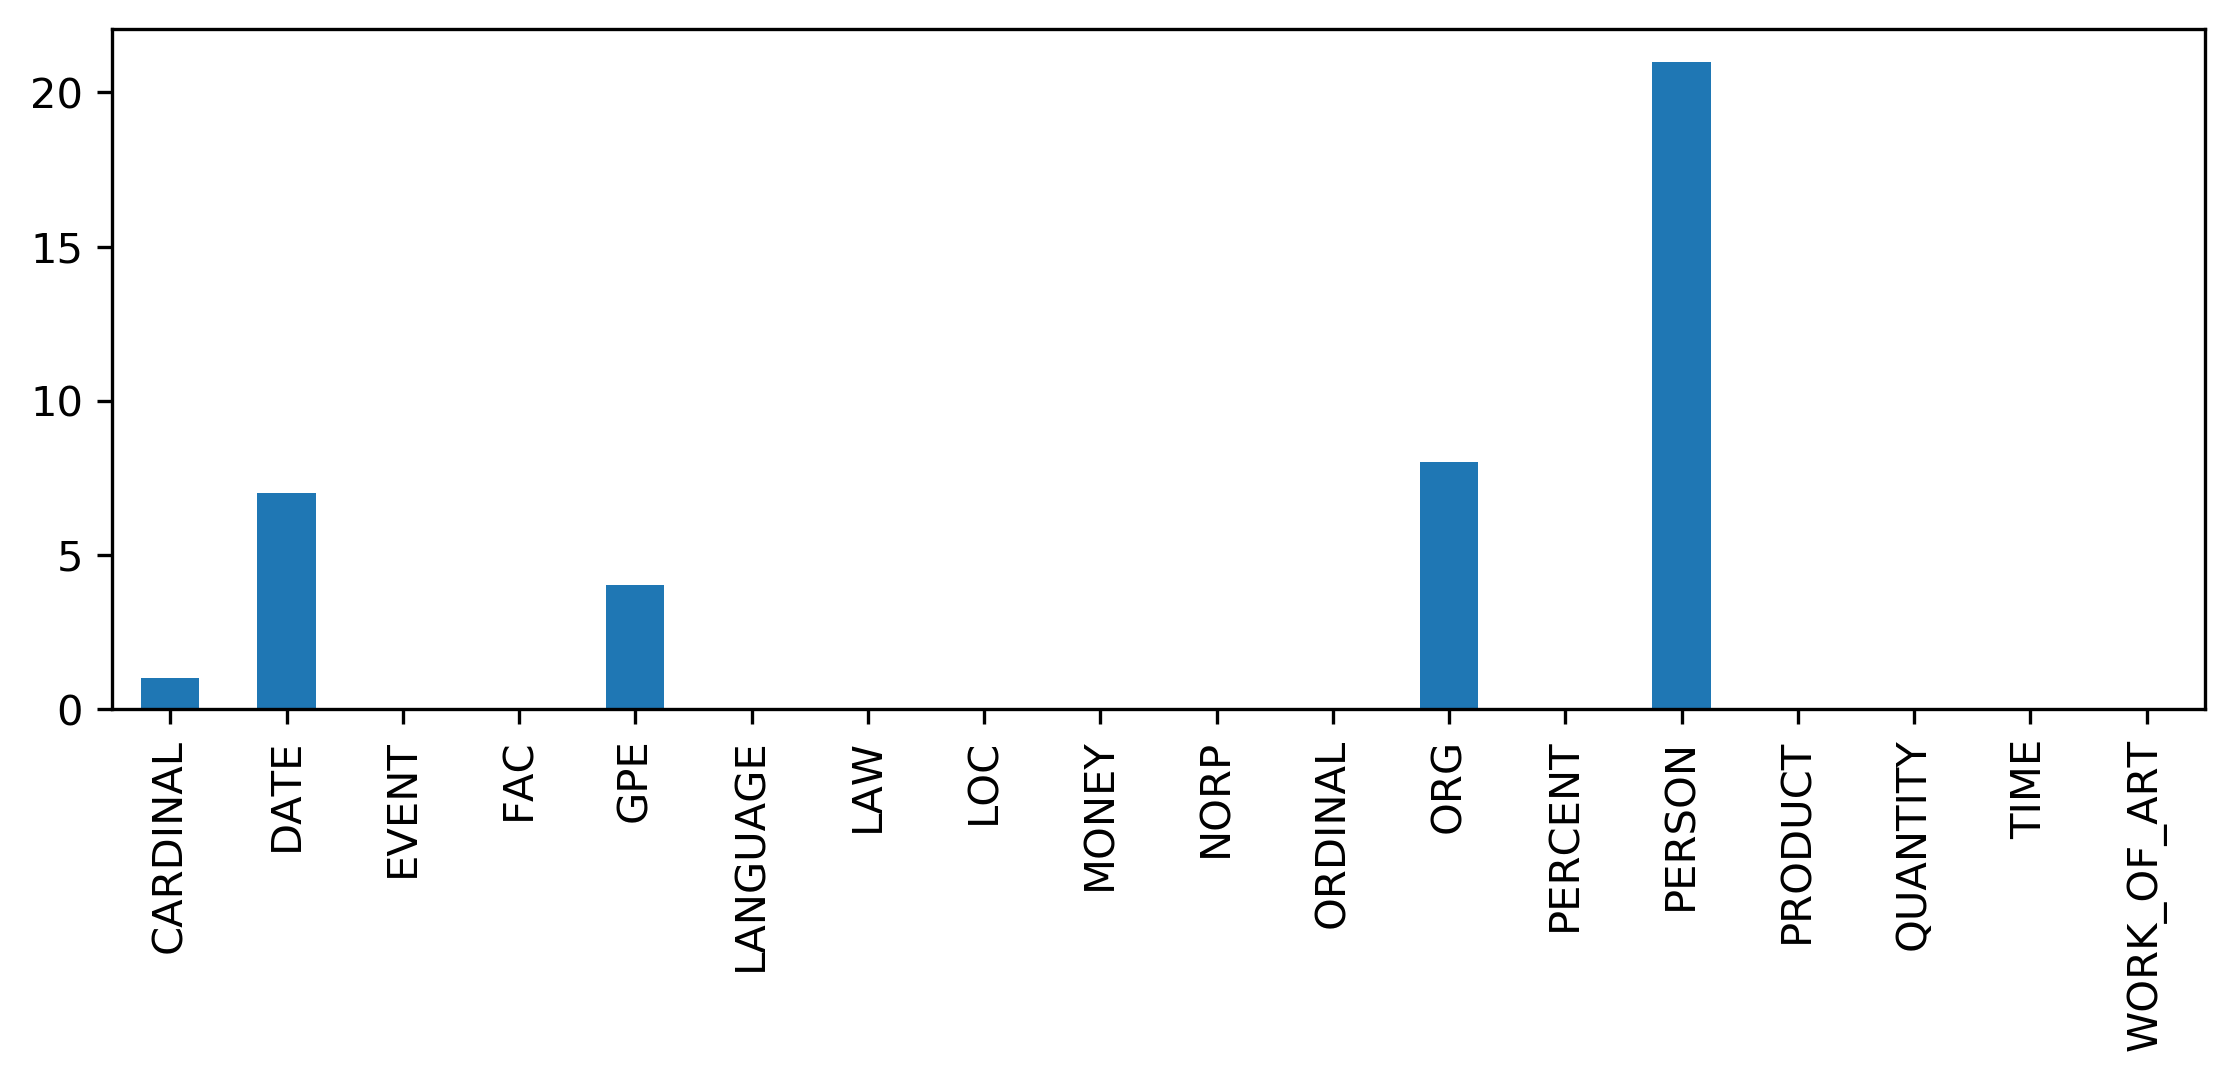

why


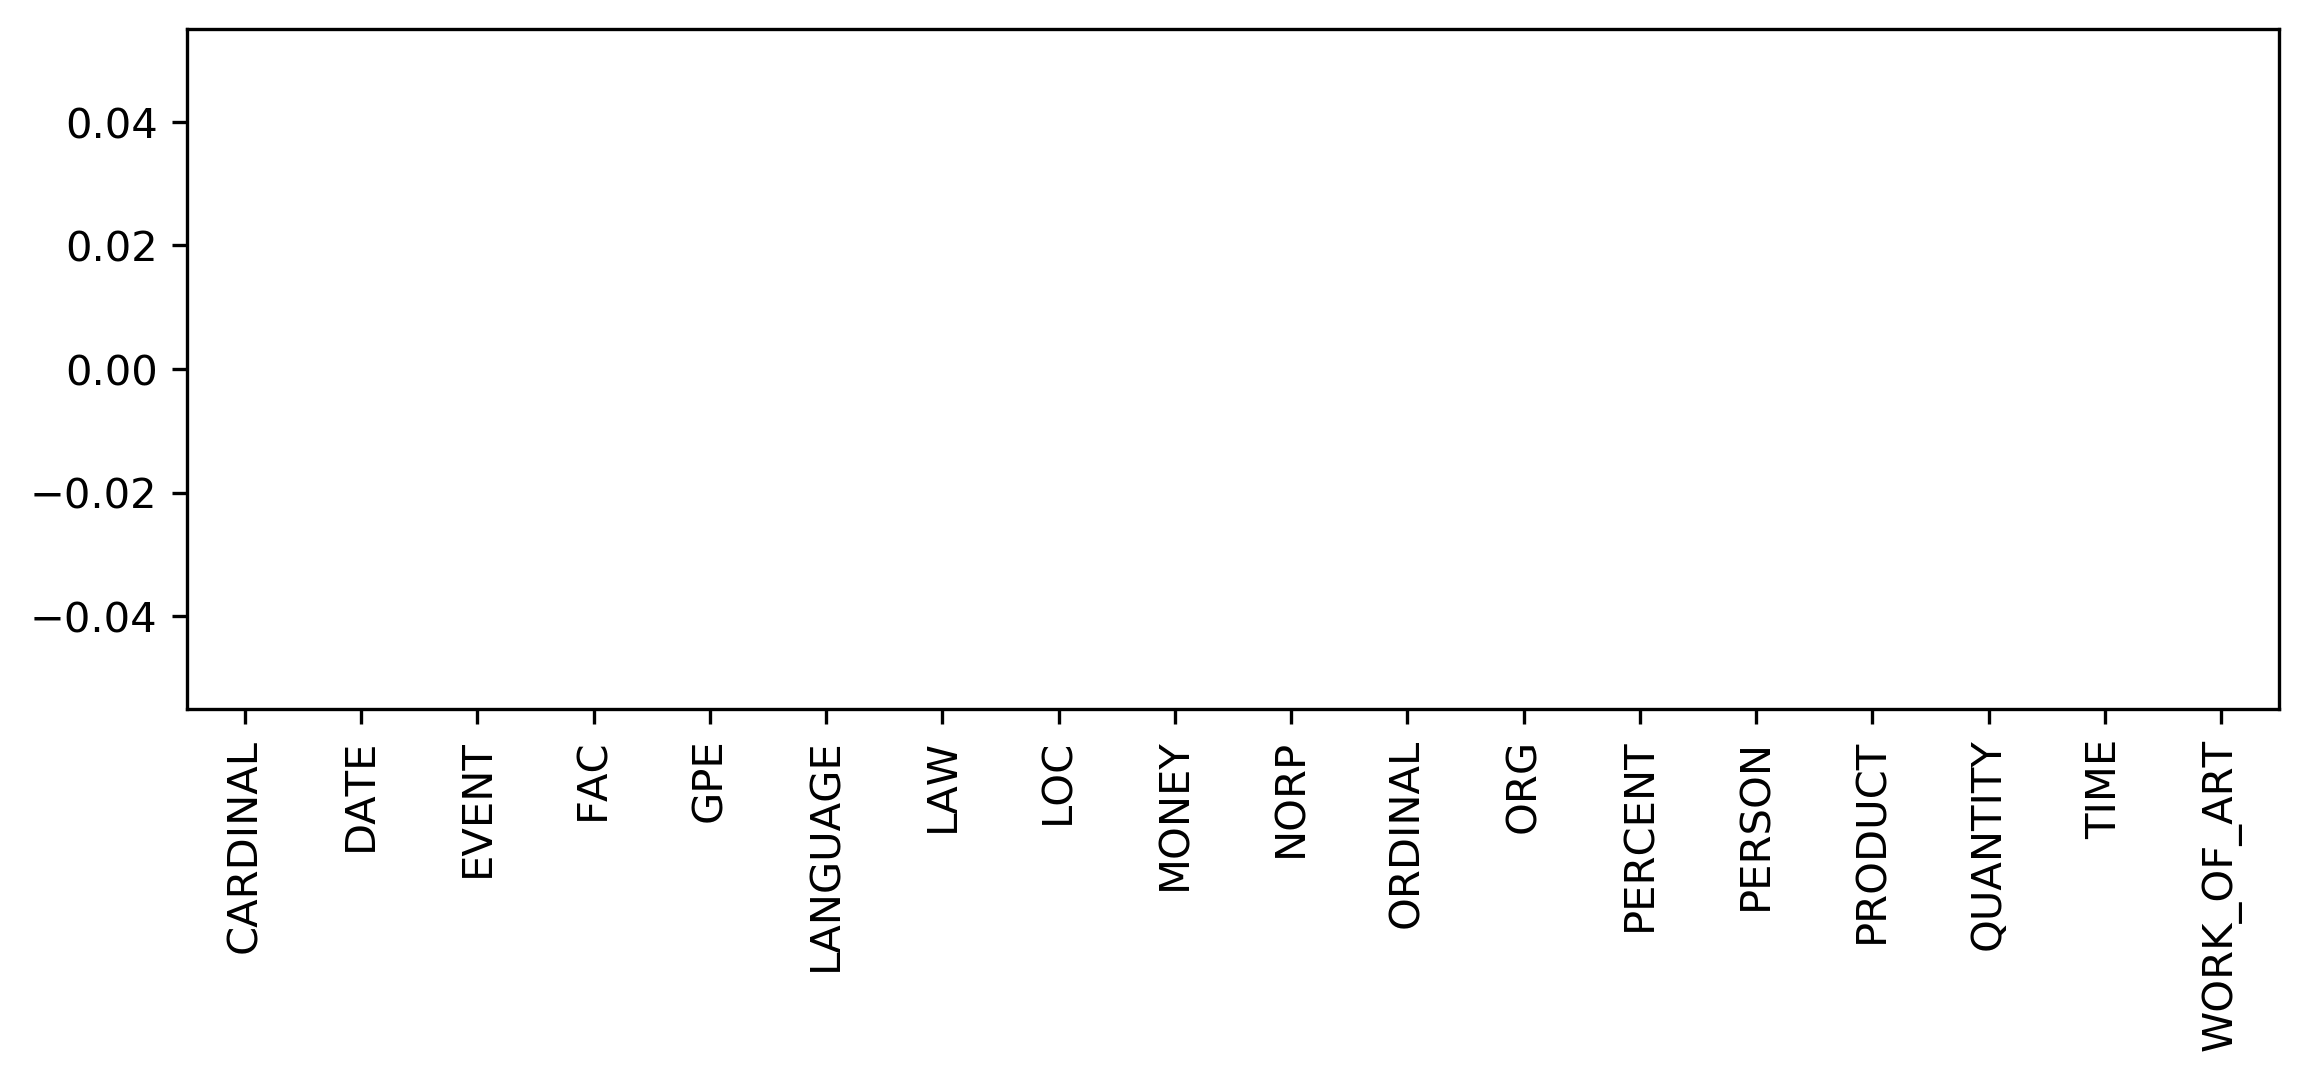

In [20]:
show_count = False
plt.rcParams["figure.dpi"] = 300
categories = {
        'who', 'what', 'which',
        'why', 'where', 'when', 'how'
    }
for category in categories:
    print(category)
    ax = df_entity[question_analysis==category].aggregate(np.sum).plot(kind='bar', figsize=(9, 3))
    if show_count:
        for p in ax.patches:
            ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.show()